In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure you have seaborn installed

## Google Colab Setup

In [ ]:
# from google.colab import drive
# # Mount Google Drive
# drive.mount('/content/drive')

In [ ]:
# from sklearn.preprocessing import StandardScaler

# def data_gen(csv_file):
#     # Read the CSV file and create a DataFrame
#     df = pd.read_csv('/content/drive/MyDrive/'+csv_file)

#     # Define your target variable
#     target_column = 'has_parkinson'
#     y = df[target_column]

#     # Drop the target column and other non-essential columns if needed
#     if 'all' in csv_file:
#         X = df.drop(columns=[target_column, 'data_group', 'event_type'])
#     else:
#         X = df.drop(columns=[target_column])

#     return [X,y]

## Local Setup

In [10]:
from sklearn.preprocessing import StandardScaler

def data_gen(csv_file):
    # Read the CSV file and create a DataFrame
    df = pd.read_csv(csv_file)

    # Define your target variable
    target_column = 'has_parkinson'
    y = df[target_column]

    # Drop the target column and other non-essential columns if needed
    if 'all' in csv_file:
        X = df.drop(columns=[target_column, 'data_group', 'event_type'])
    else:
        X = df.drop(columns=[target_column])

    return [X,y]

## All features

In [6]:
from sklearn.model_selection import train_test_split

all_feature_data = data_gen('csv_data/all/medic_features_data.csv')
# Standardize the features
scaler = StandardScaler()
X = all_feature_data[0]
X_scaled = scaler.fit_transform(all_feature_data[0])
y = all_feature_data[1]

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 25 most important features using Recursive Feature Extraction

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

most_feature_data = data_gen('csv_data/25_most_important/bi_med_rfe.csv')
X_most = all_feature_data[0]
X_most_scaled = scaler.fit_transform(all_feature_data[0])
y_most = all_feature_data[1]

# Split the dataset into training and testing sets
X_train_most, X_test_most, y_train_most, y_test_most = train_test_split(X_most_scaled, y_most, test_size=0.2, random_state=42)

## 25 most important features using Mann-Whitney U Test

In [41]:
mw_feature_data = data_gen('csv_data/25_most_important/bi_med_mw.csv')
X_mw = all_feature_data[0]
X_mw_scaled = scaler.fit_transform(all_feature_data[0])
y_mw = all_feature_data[1]

# Split the dataset into training and testing sets
X_train_mw, X_test_mw, y_train_mw, y_test_mw = train_test_split(X_mw_scaled, y_most, test_size=0.2, random_state=42)

## 20 most important features using Recursive Feature Extraction

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

most_feature_data = data_gen('csv_data/20_most_important/bi_med_rfe.csv')
X_most = all_feature_data[0]
X_most_scaled = scaler.fit_transform(all_feature_data[0])
y_most = all_feature_data[1]

# Split the dataset into training and testing sets
X_train_most, X_test_most, y_train_most, y_test_most = train_test_split(X_most_scaled, y_most, test_size=0.2, random_state=42)

## 20 most important features using Mann-Whitney U Test

In [ ]:
mw_feature_data = data_gen('csv_data/20_most_important/bi_med_mw.csv')
X_mw = all_feature_data[0]
X_mw_scaled = scaler.fit_transform(all_feature_data[0])
y_mw = all_feature_data[1]

# Split the dataset into training and testing sets
X_train_mw, X_test_mw, y_train_mw, y_test_mw = train_test_split(X_mw_scaled, y_most, test_size=0.2, random_state=42)

## Adaboost

In [33]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.graph_objects as go


def ada_boost_func(X_train,y_train,X_test,y_test):

    # Initialize an AdaBoost classifier
    n_estimators = 100
    ada_boost_clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)

    # Train the AdaBoost classifier
    ada_boost_clf.fit(X_train, y_train)

    # Initialize arrays to store accuracy and MSE values
    train_accuracy = []
    test_accuracy = []
    train_mse = []
    test_mse = []

    # Loop through different numbers of estimators and record the accuracy and MSE
    for i, estimator in enumerate(ada_boost_clf.estimators_, 1):
        train_accuracy.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, estimator.predict(X_test)))
        train_mse.append(mean_squared_error(y_train, estimator.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, estimator.predict(X_test)))

    # Convert the lists to numpy arrays
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    # Calculate accuracy and MSE for the final model
    y_train_pred = ada_boost_clf.predict(X_train)
    y_test_pred = ada_boost_clf.predict(X_test)
    final_train_accuracy = accuracy_score(y_train, y_train_pred)
    final_test_accuracy = accuracy_score(y_test, y_test_pred)
    final_train_mse = mean_squared_error(y_train, y_train_pred)
    final_test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"Final Testing Accuracy: {final_test_accuracy*100}")

    # Create a line plot for both training and testing accuracy using Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=train_accuracy, mode='lines', name='Training Accuracy'))
    fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=test_accuracy, mode='lines', name='Testing Accuracy'))

    fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                    xaxis_title='Number of Estimators',
                    yaxis_title='Accuracy')

    fig.show()

    # Create a line plot for both training and testing MSE loss using Plotly
    fig_mse = go.Figure()

    fig_mse.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=train_mse, mode='lines', name='Training MSE Loss'))
    fig_mse.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=test_mse, mode='lines', name='Testing MSE Loss'))

    fig_mse.update_layout(title='Training and Testing MSE Loss Over Epochs',
                        xaxis_title='Number of Estimators (Epochs)',
                        yaxis_title='MSE Loss')

    fig_mse.show()

    # Create a confusion matrix
    confusion = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion, display_labels=ada_boost_clf.classes_)
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

### all features

Final Testing Accuracy: 68.09701492537313


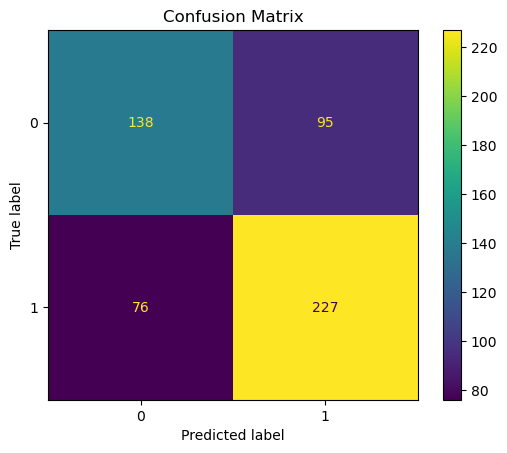

In [34]:
ada_boost_func(X_train,y_train,X_test,y_test)

### 25 features RFE

Final Testing Accuracy: 68.09701492537313


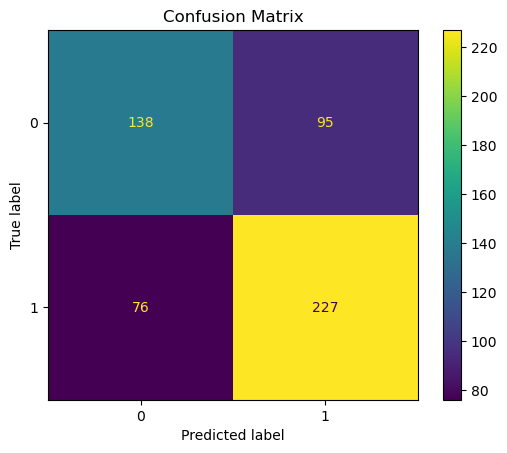

In [42]:
ada_boost_func(X_train_most,y_train_most,X_test_most,y_test_most)

### 25 features MW

Final Testing Accuracy: 68.09701492537313


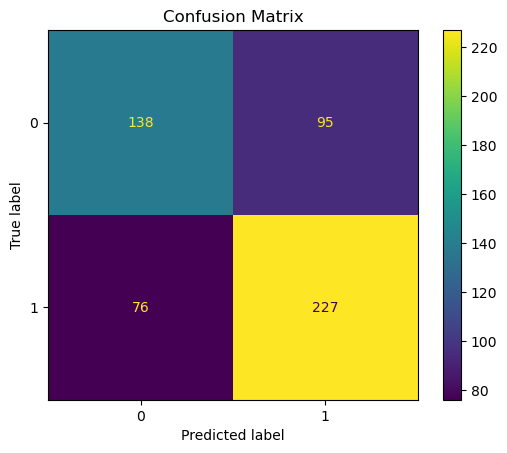

In [43]:
ada_boost_func(X_train_mw,y_train_mw,X_test_mw,y_test_mw)

## Random Forest

### All features

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, accuracy_score

# Create a RandomForestClassifier
n_estimators = 100
random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Lists to store training and testing losses
training_loss = []
testing_loss = []

# Lists to store training and testing accuracy
training_accuracy = []
testing_accuracy = []

# Train the Random Forest incrementally, capturing training and testing loss at each step
for i in range(1, n_estimators + 1):
    random_forest.fit(X_train[:i], y_train[:i])  # Incremental training
    
    # Calculate training accuracy
    y_pred_train = random_forest.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    # Append training accuracy to the list
    training_accuracy.append(accuracy_train)

    # Calculate training MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    # Append training MSE to the list
    training_loss.append(mse_train)
    
    # Calculate testing accuracy
    y_pred_test = random_forest.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Append testing accuracy to the list
    testing_accuracy.append(accuracy_test)

    # Calculate testing MSE
    mse_test = mean_squared_error(y_test, y_pred_test)
    # Append testing MSE to the list
    testing_loss.append(mse_test)
    

# random_forest_history = random_forest.fit(X_train, y_train).estimators_[0].tree_.impurity

# Fit the RandomForestClassifier to the training data
random_forest.fit(X_train, y_train)

# Get feature importances from the Random Forest model
rf_feature_importances = random_forest.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Column': X.columns, 'Feature Importance': rf_feature_importances})
rf_importance_df = rf_importance_df.sort_values(by='Feature Importance', ascending=False)

# Display the top N most important columns
top_n = 10  # Change this to the number of top features you want to display
top_features = rf_importance_df.head(top_n)
print(top_features)

                   Column  Feature Importance
5            stroke_speed            0.036593
0             finish_time            0.028083
70  acceleration_y_median            0.022992
61      velocity_y_median            0.020465
26           jerk_std_dev            0.020260
7         velocity_median            0.018271
4            relative_NCA            0.017993
39         velocity_x_iqr            0.017737
34      velocity_x_median            0.017101
24              jerk_mean            0.017098


In [25]:
# Use the trained Random Forest classifier to make predictions on the test data
y_pred_rf = random_forest.predict(X_test)

# Calculate the accuracy of the Random Forest classifier
accuracy_rf = random_forest.score(X_test, y_test)

print("Accuracy (Random Forest): {:.2f}%".format(accuracy_rf * 100))

Accuracy (Random Forest): 71.46%


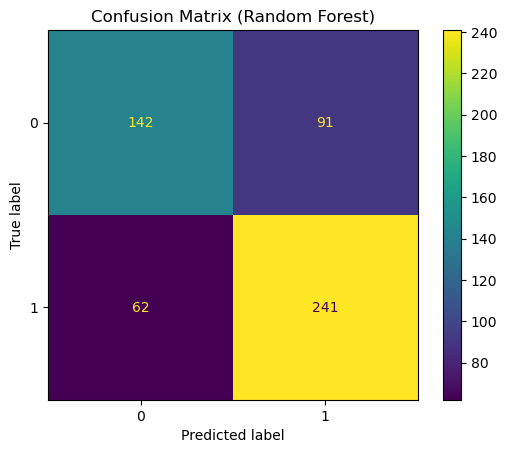

In [26]:
# Create a confusion matrix
confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix 
disp_rf = ConfusionMatrixDisplay(confusion_rf, display_labels=random_forest.classes_)
disp_rf.plot(cmap='viridis')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

In [27]:
import plotly.graph_objects as go

# Create a line plot for both training and testing MSE using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_loss, mode='lines', name='Testing Loss'))

fig.update_layout(title='Training and Testing Loss Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='MSE')

fig.show()


In [28]:
# Create a line plot for both training and testing accuracy using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_accuracy, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_accuracy, mode='lines', name='Testing Accuracy'))

fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='Accuracy')

fig.show()

### Most important features with Recursive Feature Extraction

In [46]:
# Create a RandomForestClassifier
n_estimators = 100
random_forest_most = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Lists to store training and testing losses
training_loss = []
testing_loss = []

# Lists to store training and testing accuracy
training_accuracy = []
testing_accuracy = []

# Train the Random Forest incrementally, capturing training and testing loss at each step
for i in range(1, n_estimators + 1):
    random_forest_most.fit(X_train_most[:i], y_train_most[:i])  # Incremental training
    
    # Calculate training accuracy
    y_pred_train = random_forest_most.predict(X_train_most)
    accuracy_train = accuracy_score(y_train_most, y_pred_train)
    # Append training accuracy to the list
    training_accuracy.append(accuracy_train)

    # Calculate training MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    # Append training MSE to the list
    training_loss.append(mse_train)
    
    # Calculate testing accuracy
    y_pred_test = random_forest_most.predict(X_test_most)
    accuracy_test = accuracy_score(y_test_most, y_pred_test)
    # Append testing accuracy to the list
    testing_accuracy.append(accuracy_test)

    # Calculate testing MSE
    mse_test = mean_squared_error(y_test_most, y_pred_test)
    # Append testing MSE to the list
    testing_loss.append(mse_test)
    

# random_forest_history = random_forest.fit(X_train, y_train).estimators_[0].tree_.impurity

# Fit the RandomForestClassifier to the training data
random_forest_most.fit(X_train_most, y_train_most)

RandomForestClassifier(random_state=42)

In [45]:
# Use the trained Random Forest classifier to make predictions on the test data
y_pred_rf = random_forest_most.predict(X_test_most)

# Calculate the accuracy of the Random Forest classifier
accuracy_rf = random_forest_most.score(X_test_most, y_test_most)

print("Accuracy (Random Forest): {:.2f}%".format(accuracy_rf * 100))

Accuracy (Random Forest): 71.08%


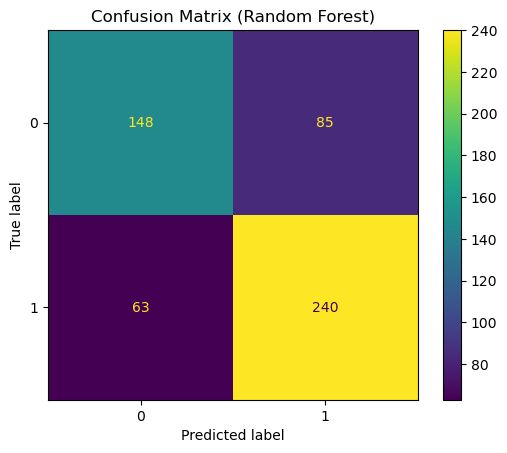

In [61]:
import plotly.graph_objects as go

# Create a confusion matrix
confusion_rf = confusion_matrix(y_test_most, y_pred_rf)

# Plot the confusion matrix 
disp_rf = ConfusionMatrixDisplay(confusion_rf, display_labels=random_forest.classes_)
disp_rf.plot(cmap='viridis')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Create a line plot for both training and testing MSE using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_loss, mode='lines', name='Testing Loss'))

fig.update_layout(title='Training and Testing Loss Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='MSE')

fig.show()

# Create a line plot for both training and testing accuracy using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_accuracy, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_accuracy, mode='lines', name='Testing Accuracy'))

fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='Accuracy')

fig.show()

Accuracy (Random Forest): 71.46%


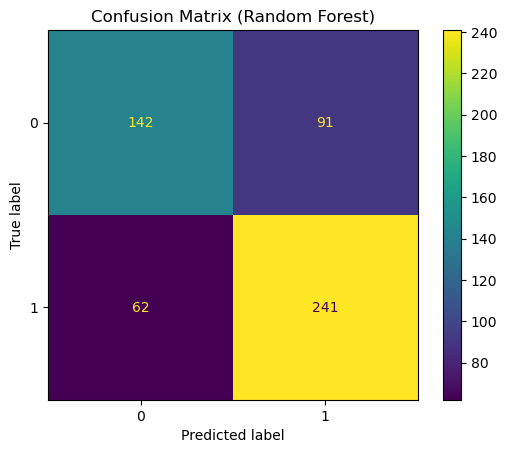

In [23]:
# Create a RandomForestClassifier
n_estimators = 100
random_forest_mw = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Lists to store training and testing losses
training_loss = []
testing_loss = []

# Lists to store training and testing accuracy
training_accuracy = []
testing_accuracy = []

# Train the Random Forest incrementally, capturing training and testing loss at each step
for i in range(1, n_estimators + 1):
    random_forest_mw.fit(X_train_mw[:i], y_train_mw[:i])  # Incremental training
    
    # Calculate training accuracy
    y_pred_train = random_forest_mw.predict(X_train_mw)
    accuracy_train = accuracy_score(y_train_mw, y_pred_train)
    # Append training accuracy to the list
    training_accuracy.append(accuracy_train)

    # Calculate training MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    # Append training MSE to the list
    training_loss.append(mse_train)
    
    # Calculate testing accuracy
    y_pred_test = random_forest_mw.predict(X_test_mw)
    accuracy_test = accuracy_score(y_test_mw, y_pred_test)
    # Append testing accuracy to the list
    testing_accuracy.append(accuracy_test)

    # Calculate testing MSE
    mse_test = mean_squared_error(y_test_mw, y_pred_test)
    # Append testing MSE to the list
    testing_loss.append(mse_test)
    

# random_forest_history = random_forest.fit(X_train, y_train).estimators_[0].tree_.impurity

# Fit the RandomForestClassifier to the training data
random_forest_mw.fit(X_train_mw, y_train_mw)
# Use the trained Random Forest classifier to make predictions on the test data
y_pred_rf = random_forest_mw.predict(X_test_mw)

# Calculate the accuracy of the Random Forest classifier
accuracy_rf = random_forest_mw.score(X_test_mw, y_test_mw)

print("Accuracy (Random Forest): {:.2f}%".format(accuracy_rf * 100))
import plotly.graph_objects as go

# Create a confusion matrix
confusion_rf = confusion_matrix(y_test_mw, y_pred_rf)

# Plot the confusion matrix 
disp_rf = ConfusionMatrixDisplay(confusion_rf, display_labels=random_forest.classes_)
disp_rf.plot(cmap='viridis')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Create a line plot for both training and testing MSE using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_loss, mode='lines', name='Testing Loss'))

fig.update_layout(title='Training and Testing Loss Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='MSE')

fig.show()

# Create a line plot for both training and testing accuracy using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_accuracy, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_accuracy, mode='lines', name='Testing Accuracy'))

fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='Accuracy')

fig.show()